## Retrieve data

In [1]:
import os
from collections import Counter
from tqdm import tqdm


data_dir = "/media/aziz/Data/Aziz/data/gans_for_apr/"

# Collect paths to files
file_paths = [root+'/'+name for root, dirs, files in tqdm(os.walk(data_dir)) for name in files]
buggy_paths, fixed_paths = [], []
buggy_paths = [f_path for f_path in tqdm(file_paths) if 'buggy' in f_path]
fixed_paths = [f_path for f_path in tqdm(file_paths) if 'fixed' in f_path]

# Collect file contents
buggy_data = []
for path in tqdm(buggy_paths):
    with open(path, 'r', encoding='utf-8') as f:
        buggy_data.append(f.read())
fixed_data = []
for path in tqdm(fixed_paths):
    with open(path, 'r', encoding='utf-8') as f:
        fixed_data.append(f.read())

print('Number of processed files:-')
print(len(buggy_data), 'buggy files +', len(fixed_data), 'fixed files = ', len(buggy_data)+len(fixed_data), 'files')

20828it [00:00, 67279.84it/s]
100%|██████████| 20826/20826 [00:00<00:00, 59963.13it/s]

Number of processed files:-
20826 buggy files + 20826 fixed files =  41652 files


## Clean data - Reduce noise

### Remove comments

In [2]:
import re


def remove_comments(code):
    code = re.sub('(?s)/\*.*?\*/', '', code)
    return re.sub('(//[^\n]*)', '', code)


buggy_no_comments = [remove_comments(x) for x in tqdm(buggy_data)]
fixed_no_comments = [remove_comments(x) for x in tqdm(fixed_data)]
print('Comments have been removed')

100%|██████████| 20826/20826 [00:00<00:00, 114349.53it/s]

Comments have been removed


### Remove unnecessary white spaces

In [3]:
def remove_spaces(code):
    '''This function removes excessive spaces and keeps necessary ones'''
    code = code.splitlines()
    result = []
    for line in code:
        line = line.split()
        line = ' '.join(line)
        if len(line) > 0:  # Remove empty lines
            result.append(line)
    
    return '\n'.join(result)


buggy_no_spaces = [remove_spaces(x) for x in tqdm(buggy_no_comments)]
fixed_no_spaces = [remove_spaces(x) for x in tqdm(fixed_no_comments)]
print('White spaces have been removed')

100%|██████████| 20826/20826 [00:00<00:00, 30611.22it/s]

White spaces have been removed


### Remove identical buggy and fixed codes

In [4]:
buggy_texts, fixed_texts = [], []
for buggy, fixed in zip(buggy_no_spaces, fixed_no_spaces):
    if buggy != fixed:
        buggy_texts.append(buggy)
        fixed_texts.append(fixed)
print(len(buggy_no_spaces)-len(buggy_texts), 'code pairs have been removed')
print('Current # data points:', len(buggy_texts))

4514 code pairs have been removed
Current # data points: 16312


### Remove duplicated pairs in the dataset

In [5]:
text_pairs = [(x, y) for x, y in zip(buggy_texts, fixed_texts)]
code_pairs = sorted(set(text_pairs))

buggy_codes = [x[0] for x in code_pairs]
fixed_codes = [x[1] for x in code_pairs]

print(len(text_pairs)-len(code_pairs), 'code pairs have been removed')
print('Current # data points:', len(buggy_codes))

3663 code pairs have been removed
Current # data points: 12649


## Calculate Diffs

In [6]:
from difflib import ndiff


initial_diffs = [list(ndiff(x.splitlines(), y.splitlines())) for x, y in tqdm(zip(buggy_codes, fixed_codes))]

12649it [00:03, 3855.27it/s]


### Restrict to one-line difference

In [7]:
one_line_diffs = []
for diff in tqdm(initial_diffs):
    if sum([1 for x in diff if x.startswith('-')]) > 1 or sum([1 for x in diff if x.startswith('+')]) > 1:
        continue
    one_line_diffs.append(diff)

print(len(initial_diffs)-len(one_line_diffs), 'code pairs have been removed')
print('Current # data points:', len(one_line_diffs))

100%|██████████| 12649/12649 [00:00<00:00, 68665.20it/s]

309 code pairs have been removed
Current # data points: 12340


### Restrict to modified lines (exclude added/deleted lines)

In [8]:
diffs = []
for diff in tqdm(one_line_diffs):
    for i, x in enumerate(diff):
        if x.startswith('+') and diff[i-1].startswith('-'):
            diffs.append((diff[i-1][2:], x[2:]))

print(len(one_line_diffs)-len(diffs), 'code pairs have been removed')
print('Current # data points:', len(diffs))

100%|██████████| 12340/12340 [00:00<00:00, 75732.06it/s]

6813 code pairs have been removed
Current # data points: 5527


#### Shuffle and keep only 5 data points

In [9]:
from random import seed, sample


seed(30)
shuf_diffs = sample(diffs, k=len(diffs))
final_diffs = shuf_diffs[:5]

buggy_data = [x[0] for x in final_diffs]
fixed_data = [x[1] for x in final_diffs]


# with open('buggy_data.txt', "w", encoding='utf-8') as file:
#     for bug in buggy_data:
#         file.write(bug+'\n')
# with open('fixed_data.txt', "w", encoding='utf-8') as file:
#     for fix in fixed_data:
#         file.write(fix+'\n')
# print('Dataset has been written to disk')

# The Experiment

In [10]:
# with open('buggy_data.txt', 'r', encoding='utf-8') as f:
#     buggy_data = f.read().split("\n")
# with open('fixed_data.txt', 'r', encoding='utf-8') as f:
#     fixed_data = f.read().split("\n")
# buggy_data = buggy_data[:-1]
# fixed_data = fixed_data[:-1]

buggy_codes = [list(x) for x in buggy_data]
fixed_codes = [['<soc>']+list(x)+['<eoc>'] for x in fixed_data]

In [11]:
print("Before vectorisation:-")
print(buggy_data[2])
print(fixed_data[2])
print("====================")
print("After vectorisation:-")
print(buggy_codes[2])
print(fixed_codes[2])

Before vectorisation:-
dest = _dpMgr.planDeployment(vmProfile, plan, exclude);
dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
After vectorisation:-
['d', 'e', 's', 't', ' ', '=', ' ', '_', 'd', 'p', 'M', 'g', 'r', '.', 'p', 'l', 'a', 'n', 'D', 'e', 'p', 'l', 'o', 'y', 'm', 'e', 'n', 't', '(', 'v', 'm', 'P', 'r', 'o', 'f', 'i', 'l', 'e', ',', ' ', 'p', 'l', 'a', 'n', ',', ' ', 'e', 'x', 'c', 'l', 'u', 'd', 'e', ')', ';']
['<soc>', 'd', 'e', 's', 't', ' ', '=', ' ', '_', 'd', 'p', 'M', 'g', 'r', '.', 'p', 'l', 'a', 'n', 'D', 'e', 'p', 'l', 'o', 'y', 'm', 'e', 'n', 't', '(', 'v', 'm', 'P', 'r', 'o', 'f', 'i', 'l', 'e', ',', ' ', 'p', 'l', 'a', 'n', ',', ' ', 'e', 'x', 'c', 'l', 'u', 'd', 'e', ',', ' ', 'n', 'u', 'l', 'l', ')', ';', '<eoc>']


In [12]:
vocab = set([x for y in buggy_codes for x in y]+[x for y in fixed_codes for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [13]:
print(int_token_map)

{1: 'w', 2: '<eoc>', 3: 's', 4: '3', 5: 'p', 6: 'J', 7: 'u', 8: '+', 9: 'g', 10: 'G', 11: '_', 12: 'L', 13: 'k', 14: 'f', 15: ';', 16: 'n', 17: 'S', 18: 'O', 19: 'E', 20: '(', 21: '6', 22: 't', 23: 'd', 24: 'x', 25: 'l', 26: 'y', 27: 'z', 28: '|', 29: 'v', 30: 'M', 31: 'm', 32: '{', 33: 'e', 34: ')', 35: '0', 36: ' ', 37: 'P', 38: 'a', 39: '.', 40: 'D', 41: '<soc>', 42: 'o', 43: '!', 44: 'r', 45: 'b', 46: '-', 47: 'c', 48: 'q', 49: ',', 50: '&', 51: '=', 52: 'i', 53: 'T', 54: 'h', 55: '1', 56: '"', 0: '<pad/unknown>'}


In [14]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in buggy_codes])
max_fixed_len = max([len(txt) for txt in fixed_codes])
num_dps = len(fixed_codes)

In [15]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 5
Vocabulary size: 57
Max length in buggy codes: 68
Max length in fixed codes: 123


In [16]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(buggy_codes, fixed_codes)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.

In [17]:
from keras.layers import Input, Concatenate, Embedding, LSTM, Dense, dot, Activation, concatenate, Lambda
from keras.models import Model
from keras.backend import argmax, cast


def build_discriminator(dimension, v_size, buggy_len, fixed_len):
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    concatted = Concatenate()([buggy_input_layer, fixed_input_layer])
    embed_lay = Embedding(v_size, dimension, mask_zero=True)(concatted)
    x = LSTM(dimension)(embed_lay)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([buggy_input_layer, fixed_input_layer], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension, mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build model
    gen = Model([buggy_input_layer, fixed_input_layer], model_output)
    
    return gen


def build_gan(gen, disc, buggy_len, fixed_len):
    disc.trainable = False
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    gen_out = gen([buggy_input_layer, fixed_input_layer])
    argmax_layer = Lambda(lambda x: cast(argmax(x, axis=2), dtype='float32'))
    disc_out = disc([buggy_input_layer, argmax_layer(gen_out)])
    gan = Model([buggy_input_layer, fixed_input_layer], [disc_out, gen_out])
    # compile model
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1, 100])
    
    return gan

Using TensorFlow backend.


W0922 13:50:34.231435 139815686342400 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 13:50:34.241297 139815686342400 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 13:50:34.245510 139815686342400 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 13:50:35.136203 139815686342400 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 123, 57)      19058745    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 123)          0           model_2[1][0]                    
__________

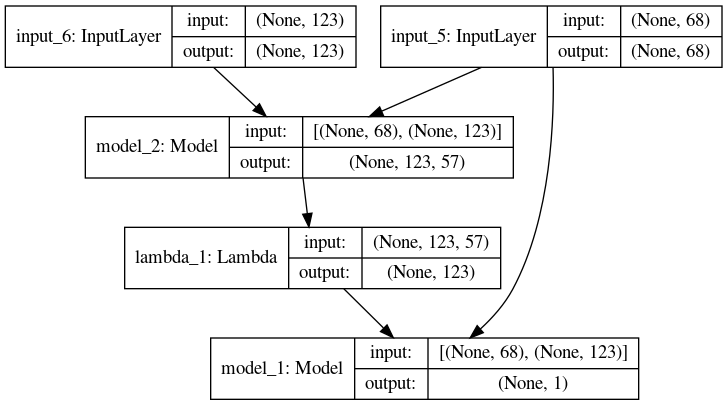

In [18]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

discriminator = build_discriminator(latent_dim, vocab_size, max_buggy_len, max_fixed_len)
plot_model(discriminator, to_file='discriminator_apr.png', show_shapes=True, show_layer_names=True)
# Image('discriminator_model_plot.png')

generator = build_generator(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(generator, to_file='generator_apr.png', show_shapes=True, show_layer_names=True)
# Image('generator_model_plot.png')

gan = build_gan(generator, discriminator, max_buggy_len, max_fixed_len)
plot_model(gan, to_file='gan_model_apr.png', show_shapes=True, show_layer_names=True)
gan.summary()
Image('gan_model_apr.png')

In [19]:
def generate_fixed_ints(gen, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<soc>"]
    for buggy, generated in zip(bugs, gntd_ints):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = gen.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eoc>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints

In [20]:
import datetime
from tqdm import tqdm


epochs = 30

start_time = datetime.datetime.now().replace(microsecond=0)
for e in tqdm(range(epochs)):
#     print('Iteration', str(e)+'/'+str(epochs)+':-')
    discriminator.fit([buggy_inputs, fixed_inputs], np.ones(num_dps))
    generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    discriminator.fit([buggy_inputs, generated_ints], np.zeros(num_dps))
    gan.fit([buggy_inputs, fixed_inputs], [np.ones(num_dps), fixed_outputs])
end_time = datetime.datetime.now().replace(microsecond=0)

  0%|          | 0/30 [00:00<?, ?it/s]/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5/5 [==============================] - 3s 676ms/step - loss: 0.3486 - acc: 0.0000e+00


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5/5 [==============================] - 0s 51ms/step - loss: 0.3755 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 2s 475ms/step - loss: 404.7260 - model_1_loss: 0.6356 - model_2_loss: 4.0409


  3%|▎         | 1/30 [00:58<28:10, 58.31s/it]

Epoch 1/1


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 0s 54ms/step - loss: 0.2302 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.5647 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 360.4501 - model_1_loss: 0.8115 - model_2_loss: 3.5964


  7%|▋         | 2/30 [01:48<26:05, 55.90s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.1800 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.2219 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 1033.6814 - model_1_loss: 1.5021 - model_2_loss: 10.3218


 10%|█         | 3/30 [02:39<24:25, 54.28s/it]

Epoch 1/1
5/5 [==============================] - 0s 55ms/step - loss: 0.1567 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.4169 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 74ms/step - loss: 1036.6902 - model_1_loss: 0.9308 - model_2_loss: 10.3576


 13%|█▎        | 4/30 [03:29<23:00, 53.09s/it]

Epoch 1/1
5/5 [==============================] - 0s 56ms/step - loss: 0.1228 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.3811 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 72ms/step - loss: 857.0901 - model_1_loss: 0.8863 - model_2_loss: 8.5620


 17%|█▋        | 5/30 [04:19<21:46, 52.28s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0906 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.3577 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 789.3151 - model_1_loss: 1.1222 - model_2_loss: 7.8819


 20%|██        | 6/30 [05:10<20:39, 51.66s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0612 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 52ms/step - loss: 0.3799 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 70ms/step - loss: 695.7437 - model_1_loss: 1.2994 - model_2_loss: 6.9444


 23%|██▎       | 7/30 [06:00<19:38, 51.24s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0378 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0496 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 70ms/step - loss: 650.2051 - model_1_loss: 3.8556 - model_2_loss: 6.4635


 27%|██▋       | 8/30 [06:50<18:40, 50.91s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0236 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 2.3668 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 608.8936 - model_1_loss: 0.4759 - model_2_loss: 6.0842


 30%|███       | 9/30 [07:40<17:45, 50.73s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0114 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 51ms/step - loss: 0.0800 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 74ms/step - loss: 593.4248 - model_1_loss: 1.7535 - model_2_loss: 5.9167


 33%|███▎      | 10/30 [08:30<16:51, 50.59s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0104 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.4692 - acc: 0.2000
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 577.1407 - model_1_loss: 1.0104 - model_2_loss: 5.7613


 37%|███▋      | 11/30 [09:21<15:59, 50.52s/it]

Epoch 1/1
5/5 [==============================] - 0s 56ms/step - loss: 0.0241 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 55ms/step - loss: 0.1008 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 70ms/step - loss: 567.6517 - model_1_loss: 1.7684 - model_2_loss: 5.6588


 40%|████      | 12/30 [10:11<15:09, 50.51s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0681 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.1685 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 74ms/step - loss: 557.7672 - model_1_loss: 1.3537 - model_2_loss: 5.5641


 43%|████▎     | 13/30 [11:02<14:17, 50.47s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0465 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0744 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 73ms/step - loss: 551.7389 - model_1_loss: 2.1302 - model_2_loss: 5.4961


 47%|████▋     | 14/30 [11:52<13:27, 50.45s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0596 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.1091 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 538.6233 - model_1_loss: 1.7922 - model_2_loss: 5.3683


 50%|█████     | 15/30 [12:42<12:35, 50.34s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0619 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0327 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 73ms/step - loss: 533.7571 - model_1_loss: 3.2267 - model_2_loss: 5.3053


 53%|█████▎    | 16/30 [13:33<11:44, 50.36s/it]

Epoch 1/1
5/5 [==============================] - 0s 56ms/step - loss: 0.0506 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 52ms/step - loss: 0.0466 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 72ms/step - loss: 530.2085 - model_1_loss: 2.8679 - model_2_loss: 5.2734


 57%|█████▋    | 17/30 [14:24<10:57, 50.60s/it]

Epoch 1/1
5/5 [==============================] - 0s 52ms/step - loss: 0.0468 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0040 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 73ms/step - loss: 527.3343 - model_1_loss: 5.3089 - model_2_loss: 5.2203


 60%|██████    | 18/30 [15:14<10:05, 50.46s/it]

Epoch 1/1
5/5 [==============================] - 0s 59ms/step - loss: 0.0605 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 51ms/step - loss: 0.0197 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 72ms/step - loss: 521.5259 - model_1_loss: 3.1186 - model_2_loss: 5.1841


 63%|██████▎   | 19/30 [16:04<09:15, 50.46s/it]

Epoch 1/1
5/5 [==============================] - 0s 52ms/step - loss: 0.0203 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 51ms/step - loss: 0.0059 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 523.5502 - model_1_loss: 4.2807 - model_2_loss: 5.1927


 67%|██████▋   | 20/30 [16:55<08:24, 50.41s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0125 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 55ms/step - loss: 0.4556 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 72ms/step - loss: 520.9617 - model_1_loss: 0.6386 - model_2_loss: 5.2032


 70%|███████   | 21/30 [17:45<07:33, 50.38s/it]

Epoch 1/1
5/5 [==============================] - 0s 55ms/step - loss: 0.0091 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0345 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 72ms/step - loss: 526.8314 - model_1_loss: 2.7695 - model_2_loss: 5.2406


 73%|███████▎  | 22/30 [18:35<06:42, 50.36s/it]

Epoch 1/1
5/5 [==============================] - 0s 55ms/step - loss: 0.0072 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 52ms/step - loss: 0.0140 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 524.8616 - model_1_loss: 3.6514 - model_2_loss: 5.2121


 77%|███████▋  | 23/30 [19:26<05:52, 50.38s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0058 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0255 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 73ms/step - loss: 528.6083 - model_1_loss: 3.1928 - model_2_loss: 5.2542


 80%|████████  | 24/30 [20:16<05:02, 50.40s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0047 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0091 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 72ms/step - loss: 528.8937 - model_1_loss: 4.3573 - model_2_loss: 5.2454


 83%|████████▎ | 25/30 [21:07<04:11, 50.40s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0039 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 52ms/step - loss: 0.0100 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 73ms/step - loss: 522.2582 - model_1_loss: 4.3278 - model_2_loss: 5.1793


 87%|████████▋ | 26/30 [21:57<03:21, 50.34s/it]

Epoch 1/1
5/5 [==============================] - 0s 56ms/step - loss: 0.0033 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0012 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 73ms/step - loss: 525.5598 - model_1_loss: 6.7313 - model_2_loss: 5.1883


 90%|█████████ | 27/30 [22:47<02:31, 50.34s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0029 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 51ms/step - loss: 3.1247e-04 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 70ms/step - loss: 531.0739 - model_1_loss: 7.6808 - model_2_loss: 5.2339


 93%|█████████▎| 28/30 [23:37<01:40, 50.30s/it]

Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 0.0026 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 1.0923e-04 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 70ms/step - loss: 531.7266 - model_1_loss: 8.8434 - model_2_loss: 5.2288


 97%|█████████▋| 29/30 [24:28<00:50, 50.35s/it]

Epoch 1/1
5/5 [==============================] - 0s 53ms/step - loss: 0.0024 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 54ms/step - loss: 5.1028e-05 - acc: 1.0000
Epoch 1/1
5/5 [==============================] - 0s 71ms/step - loss: 531.2900 - model_1_loss: 9.4934 - model_2_loss: 5.2180


100%|██████████| 30/30 [25:18<00:00, 50.37s/it]


In [21]:
print("Training took (h:mm:ss)", end_time-start_time)

def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

Training took (h:mm:ss) 0:25:19


In [22]:
generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(buggy_codes, fixed_codes, generated_codes):
    print('Buggy code:', ''.join(buggy))
    print('Fixed code:', ''.join(fixed[1:-1]))
    print('Genration: ', ''.join(gnrtd[1:]))
    print('=============')

Buggy code: String toTest = "woordenboek_nederlands-3.1.1-sm+tb+fx+fn.xpi";
Fixed code: String toTest = "turkmen_spell_checker_dictionary-0.1.6-tb+fx+sm.xpi";
Genration:  itiiiiinsstttlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
Buggy code: || (this.collator != null && ! this.collator.equals(other.collator))
Fixed code: || (this.collator != null && ! this.collator.equals(other.collator) || (this.collator == null && other.collator != null))
Genration:  itiiiiinisttttllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
Buggy code: dest = _dpMgr.planDeployment(vmProfile, plan, exclude);
Fixed code: dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
Genration:  itiiiiinsstttlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
Buggy code: LOG.info(clazz + " is not a valid POJO type");
Fixed code: LOG.info